In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity

In [2]:
import os
import sys
import gc
import time
import math
import collections
import psutil
import pickle 
from datetime import date, datetime, timedelta
from copy import deepcopy
from tqdm import tqdm

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor 
from sklearn.model_selection import cross_validate

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import optuna

In [3]:
# read files
DATA_PATH = "/kaggle/input/predict-energy-behavior-of-prosumers"

train = pd.read_csv(f'{DATA_PATH}/train.csv')
gas_prices = pd.read_csv(f'{DATA_PATH}/gas_prices.csv')
client = pd.read_csv(f'{DATA_PATH}/client.csv')
electricity_prices = pd.read_csv(f'{DATA_PATH}/electricity_prices.csv')
historical_weather = pd.read_csv(f'{DATA_PATH}/historical_weather.csv')
forecast_weather = pd.read_csv(f'{DATA_PATH}/forecast_weather.csv')

In [4]:
# memory
memory_info = psutil.virtual_memory()

print("total：", memory_info.total, "bytes")
print("used：", memory_info.used, "bytes")
print("free：", memory_info.available, "bytes")
print("percent：", memory_info.percent, "%")

total： 33669922816 bytes
used： 2152534016 bytes
free： 31039270912 bytes
percent： 7.8 %


# train

In [5]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [6]:
train['datetime'] = pd.to_datetime(train['datetime'])

In [7]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


In [8]:
# correlation
train.corr().round(2)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
county,1.00,0.03,0.01,-0.10,0.0,0.00,0.00,0.00,0.78
is_business,0.03,1.00,-0.09,0.16,-0.0,0.02,0.02,0.02,0.16
product_type,0.01,-0.09,1.00,0.17,0.0,-0.02,-0.02,-0.02,-0.09
target,-0.10,0.16,0.17,1.00,0.2,0.04,0.04,0.04,-0.11
is_consumption,0.00,-0.00,0.00,0.20,1.0,-0.00,0.00,0.00,-0.00
datetime,0.00,0.02,-0.02,0.04,-0.0,1.00,1.00,1.00,0.03
data_block_id,0.00,0.02,-0.02,0.04,0.0,1.00,1.00,1.00,0.03
row_id,0.00,0.02,-0.02,0.04,0.0,1.00,1.00,1.00,0.03
prediction_unit_id,0.78,0.16,-0.09,-0.11,-0.0,0.03,0.03,0.03,1.00


<Axes: xlabel='county', ylabel='target'>

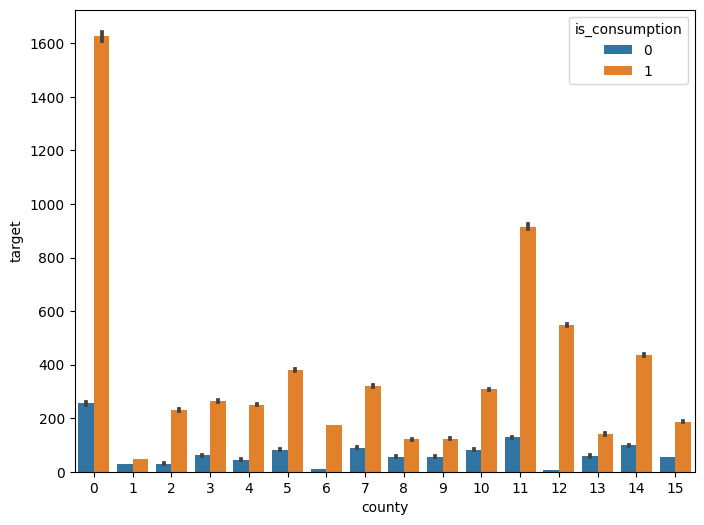

In [9]:
# county
plt.figure(figsize=(8, 6))
sns.barplot(x='county', y='target', hue='is_consumption', data=train)  # average by default

<Axes: xlabel='is_business', ylabel='target'>

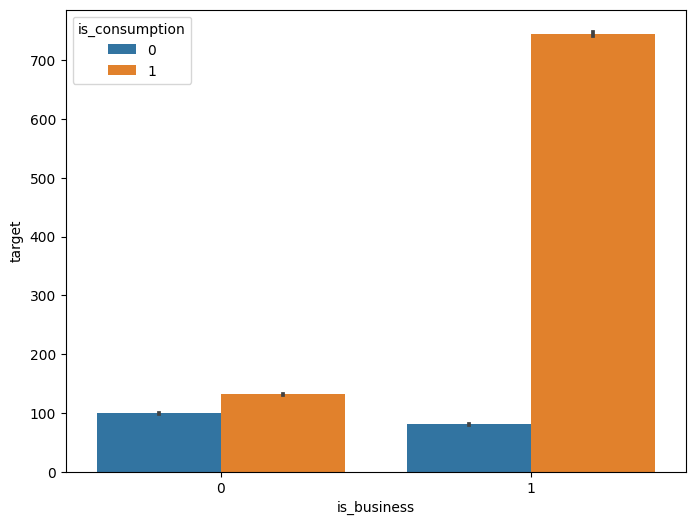

In [10]:
# is_business
plt.figure(figsize=(8, 6))
sns.barplot(x='is_business', y='target', hue='is_consumption', data=train)

<Axes: xlabel='product_type', ylabel='target'>

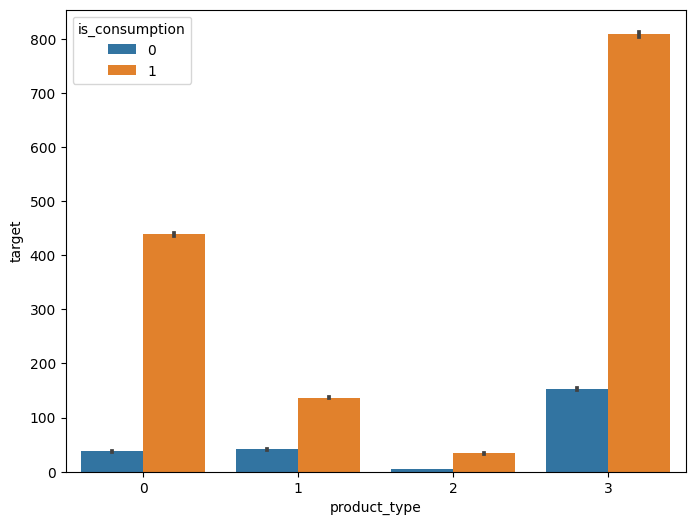

In [11]:
# product_type
plt.figure(figsize=(8, 6))
sns.barplot(x='product_type', y='target', hue='is_consumption', data=train)

In [12]:
# datetime
single_country_consumption = train.loc[(train['is_consumption'] == 1) & (train['prediction_unit_id'] == 0)]
single_country_production = train.loc[(train['is_consumption'] == 0) & (train['prediction_unit_id'] == 0)]

single_country_consumption = single_country_consumption.set_index('datetime')
single_country_production = single_country_production.set_index('datetime')

single_country_consumption['month'] = single_country_consumption.index.month
single_country_consumption['weekday'] = single_country_consumption.index.weekday
single_country_consumption['hour'] = single_country_consumption.index.hour
single_country_production['month'] = single_country_production.index.month
single_country_production['weekday'] = single_country_production.index.weekday
single_country_production['hour'] = single_country_production.index.hour

In [13]:
print(single_country_consumption.shape, single_country_production.shape)

(15312, 11) (15312, 11)


<Axes: xlabel='month'>

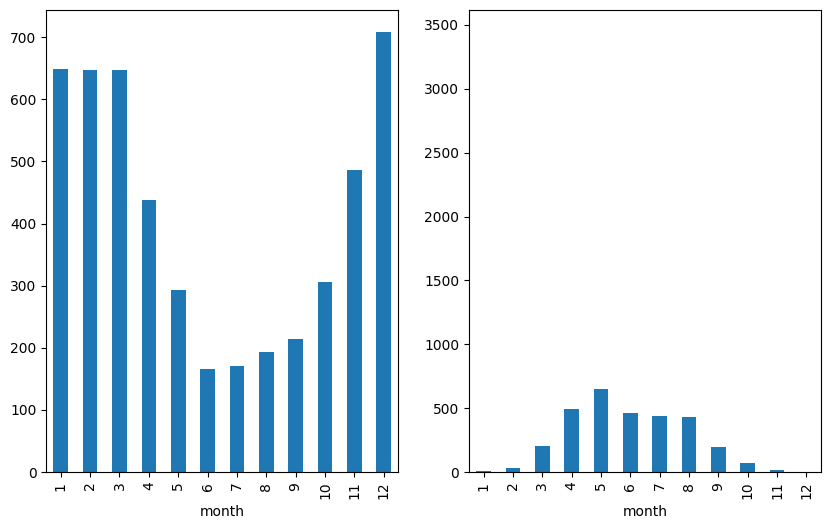

In [14]:
# month
plt.figure(figsize=(10, 6))
plt.subplot(121)  # 1_row, 2_cols, current one is the first firgure
single_country_consumption.groupby('month')['target'].mean().plot(kind='bar')

plt.subplot(122)
single_country_production['target'].plot()
single_country_production.groupby('month')['target'].mean().plot(kind='bar')

<Axes: xlabel='weekday'>

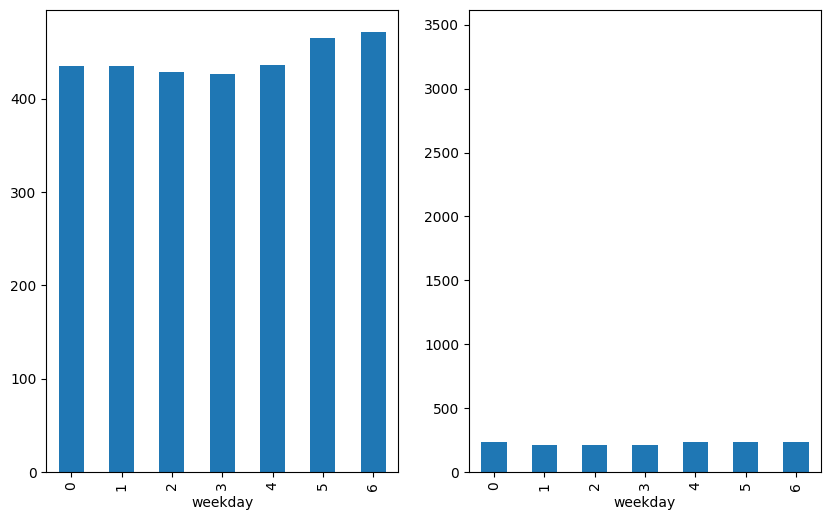

In [15]:
# weekday
plt.figure(figsize=(10, 6))
plt.subplot(121)
single_country_consumption.groupby('weekday')['target'].mean().plot(kind='bar')

plt.subplot(122)
single_country_production['target'].plot()
single_country_production.groupby('weekday')['target'].mean().plot(kind='bar')

# gas prices

In [16]:
gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [17]:
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])

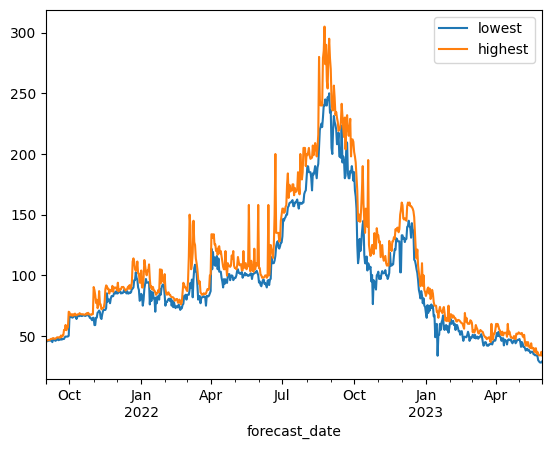

In [18]:
gas_prices.set_index('forecast_date')['lowest_price_per_mwh'].plot()
gas_prices.set_index('forecast_date')['highest_price_per_mwh'].plot()
plt.legend(['lowest', 'highest'])

In [19]:
single_country_consumption = train.loc[(train['is_consumption'] == 1) & (train['prediction_unit_id'] == 0)]
single_country_production = train.loc[(train['is_consumption'] == 0) & (train['prediction_unit_id'] == 0)]

single_country_consumption = pd.merge(single_country_consumption, gas_prices, on='data_block_id', how='left')
single_country_consumption = single_country_consumption.dropna()

single_country_production = pd.merge(single_country_production, gas_prices, on='data_block_id', how='left')
single_country_production = single_country_production.dropna()

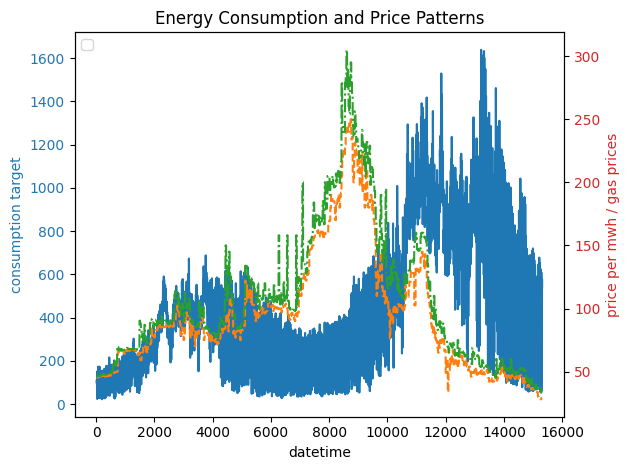

In [20]:
import matplotlib.pyplot as plt

# Assuming single_country_consumption is your DataFrame
fig, ax1 = plt.subplots()

# Plot the first feature using the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('datetime')
ax1.set_ylabel('consumption target', color=color)
ax1.plot(single_country_consumption.index, single_country_consumption['target'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second and third features
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('price per mwh / gas prices', color=color)
ax2.plot(single_country_consumption.index, single_country_consumption['lowest_price_per_mwh'], color='tab:orange', linestyle='--')
ax2.plot(single_country_consumption.index, single_country_consumption['highest_price_per_mwh'], color='tab:green', linestyle='-.')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend manually
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Other customizations
plt.title('Energy Consumption and Price Patterns')
fig.tight_layout()  # Adjust layout to make room for the legend

plt.show()

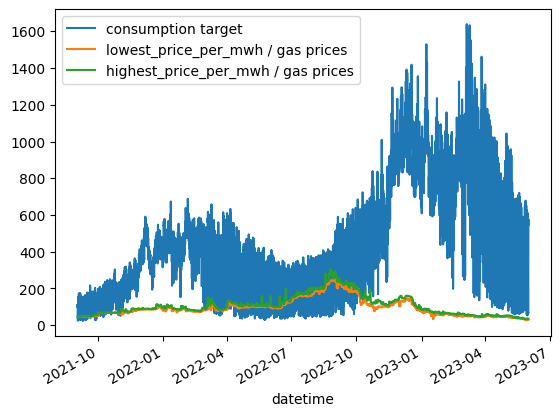

In [21]:
single_country_consumption.set_index('datetime')['target'].plot()
single_country_consumption.set_index('datetime')['lowest_price_per_mwh'].plot()
single_country_consumption.set_index('datetime')['highest_price_per_mwh'].plot()

plt.legend(['consumption target', 'lowest_price_per_mwh / gas prices', 'highest_price_per_mwh / gas prices'])

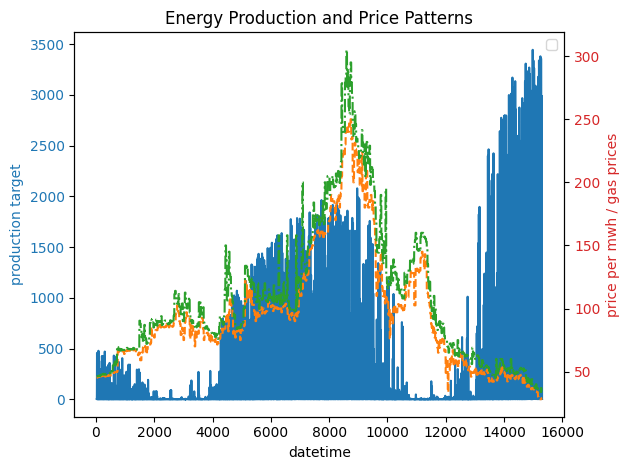

In [22]:
fig, ax1 = plt.subplots()

# Plotting 'production target' on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('datetime')
ax1.set_ylabel('production target', color=color)
ax1.plot(single_country_production.index, single_country_production['target'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for 'lowest_price_per_mwh' and 'highest_price_per_mwh'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('price per mwh / gas prices', color=color)  
ax2.plot(single_country_production.index, single_country_production['lowest_price_per_mwh'], color='tab:orange', linestyle='--')
ax2.plot(single_country_production.index, single_country_production['highest_price_per_mwh'], color='tab:green', linestyle='-.')
ax2.tick_params(axis='y', labelcolor=color)

# Adding legend that combines elements from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

plt.title('Energy Production and Price Patterns')
fig.tight_layout()  # adjust layout to make room for the legend

plt.show()

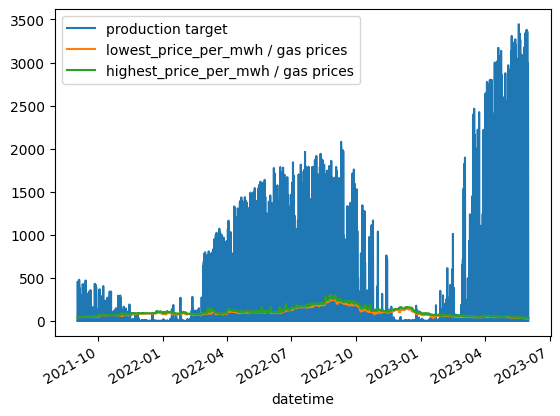

In [23]:
single_country_production.set_index('datetime')['target'].plot()
single_country_production.set_index('datetime')['lowest_price_per_mwh'].plot()
single_country_production.set_index('datetime')['highest_price_per_mwh'].plot()

plt.legend(['production target', 'lowest_price_per_mwh / gas prices', 'highest_price_per_mwh / gas prices'])

# client

In [24]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [25]:
client['date'] = pd.to_datetime(client['date'])

<Axes: >

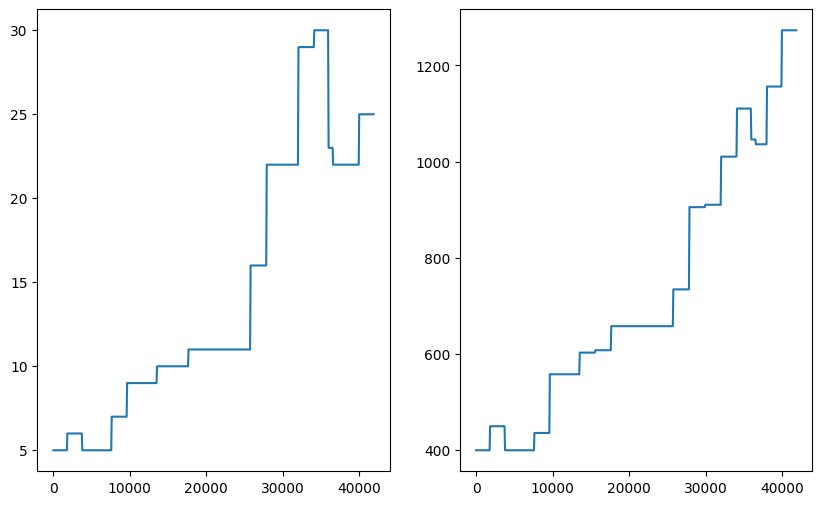

In [26]:
# eic_count
plt.figure(figsize=(10, 6))
plt.subplot(121)
client.loc[
    (client['county'] == 0) & (client['product_type'] == 0)
]['eic_count'].plot()

# installed_capacity
plt.subplot(122)
client.loc[
    (client['county'] == 0) & (client['product_type'] == 0)
]['installed_capacity'].plot()

In [27]:
single_country_consumption = train.loc[(train['is_consumption'] == 1) & (train['prediction_unit_id'] == 0)]
single_country_production = train.loc[(train['is_consumption'] == 0) & (train['prediction_unit_id'] == 0)]

single_country_consumption = pd.merge(single_country_consumption, client,
                                      on=['data_block_id', 'product_type', 'county', 'is_business'], how='left')
single_country_consumption = single_country_consumption.dropna()

single_country_production = pd.merge(single_country_production,
                                     client,
                                     on=['data_block_id', 'product_type', 'county', 'is_business'], how='left')
single_country_production = single_country_production.dropna()

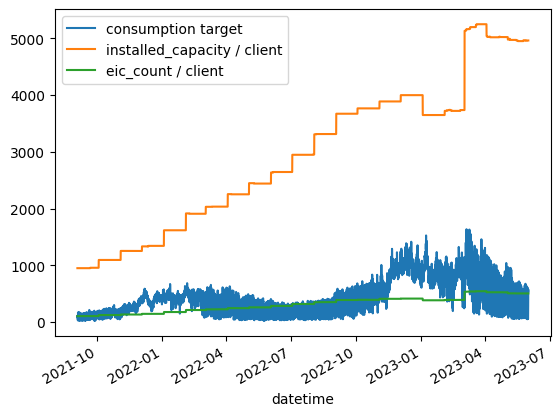

In [28]:
single_country_consumption.set_index('datetime')['target'].plot()
single_country_consumption.set_index('datetime')['installed_capacity'].plot()
single_country_consumption.set_index('datetime')['eic_count'].plot()

plt.legend(['consumption target', 'installed_capacity / client', 'eic_count / client'])

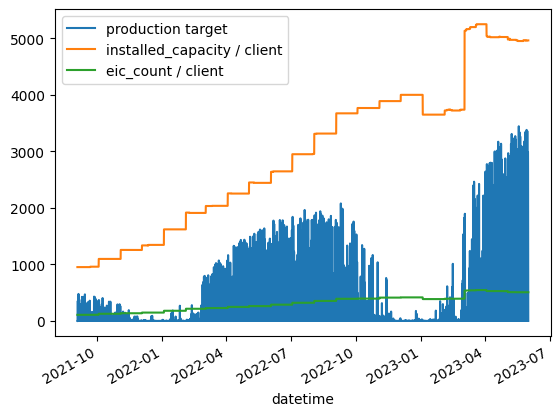

In [29]:
single_country_production.set_index('datetime')['target'].plot()
single_country_production.set_index('datetime')['installed_capacity'].plot()
single_country_production.set_index('datetime')['eic_count'].plot()

plt.legend(['production target', 'installed_capacity / client', 'eic_count / client'])

# electricity prcice

In [30]:
electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [31]:
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])

<Axes: xlabel='forecast_date'>

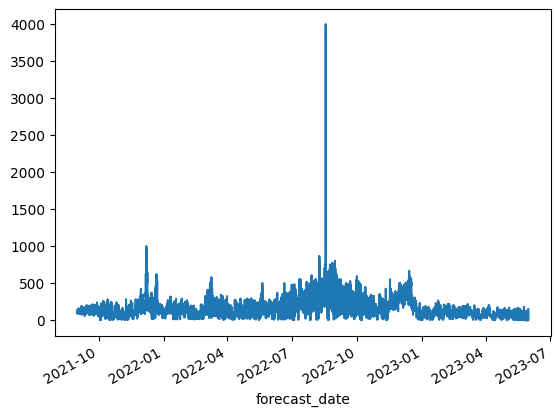

In [32]:
electricity_prices.set_index('forecast_date')['euros_per_mwh'].plot()

In [33]:
single_country_consumption = train.loc[(train['is_consumption'] == 1) & (train['prediction_unit_id'] == 0)]
single_country_production = train.loc[(train['is_consumption'] == 0) & (train['prediction_unit_id'] == 0)]

single_country_consumption = pd.merge(single_country_consumption, electricity_prices, on='data_block_id', how='left')
single_country_consumption = single_country_consumption.dropna()

single_country_production = pd.merge(single_country_production, electricity_prices, on='data_block_id', how='left')
single_country_production = single_country_production.dropna()

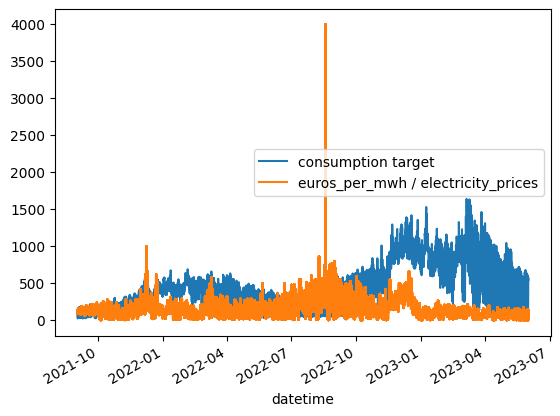

In [34]:
single_country_consumption.set_index('datetime')['target'].plot()
single_country_consumption.set_index('datetime')['euros_per_mwh'].plot()

plt.legend(['consumption target', 'euros_per_mwh / electricity_prices'])

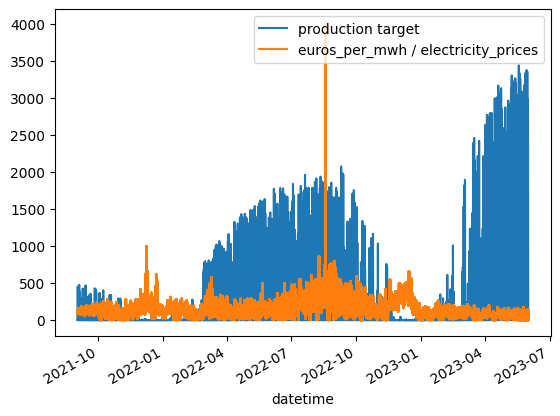

In [35]:
single_country_production.set_index('datetime')['target'].plot()
single_country_production.set_index('datetime')['euros_per_mwh'].plot()

plt.legend(['production target', 'euros_per_mwh / electricity_prices'])

# historical weather

In [36]:
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [37]:
historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

In [38]:
historical_weather[['latitude', 'longitude']].value_counts()

latitude  longitude
57.6      23.2         15276
          24.2         15276
          21.7         15275
59.1      22.2         15275
          27.7         15275
                       ...  
58.2      25.2         15275
          24.7         15275
          24.2         15275
          23.7         15275
59.7      28.2         15275
Name: count, Length: 112, dtype: int64

# forecast weather

In [39]:
forecast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [40]:
forecast_weather['forecast_datetime'] = pd.to_datetime(forecast_weather['forecast_datetime'])

In [41]:
forecast_weather[['latitude', 'longitude']].value_counts()  # same as historical

latitude  longitude
57.6      21.7         30576
          22.2         30576
59.1      27.7         30576
          27.2         30576
          26.7         30576
                       ...  
58.2      24.2         30576
          23.7         30576
          23.2         30576
          22.7         30576
59.7      28.2         30576
Name: count, Length: 112, dtype: int64